In [1]:
%matplotlib inline
import os
from collections import OrderedDict
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from data import CodesInDbs, Mappings, Databases
from IPython.display import Latex

pd.set_option('display.max_colwidth', 100)

sns.set_style('whitegrid')
#sns.set_context("poster")
#plt.rcParams['figure.figsize'] = (4, 3)
plt.rc("savefig", dpi=150)

measures_palette = sns.color_palette('Set1', n_colors=2, desat=.5)
measures_palette.reverse()

def graded_recall_palette(n_colors):
    palette = sns.color_palette("Blues", n_colors=n_colors, desat=.6)
    palette.reverse()
    return palette

def graded_precision_palette(n_colors):
    palette = sns.color_palette("Reds", n_colors=n_colors, desat=.6)
    palette.reverse()
    return palette

def mystyle(palette=None, xrot=0, ha='center', ylim=(0,1), ylabel=None, savefig=None):
    class C:
        def __enter__(self):
            if palette is not None:
                palette.__enter__()
        def __exit__(self, exc_type, value, traceback):
            if palette is not None:
                palette.__exit__(exc_type, value, traceback)
            if exc_type is None:
                sns.despine(left=True)
                plt.grid(False, axis='x')
                if plt.gca().legend_: 
                    lgd=plt.legend(loc=2, bbox_to_anchor=(1, 1))
                else:
                    lgd=None
                plt.gca().get_lines()[0].set_visible(False)
                plt.gca().set_ylim(*ylim)
                plt.xticks(rotation=xrot, ha=ha)
                if ylabel is not None:
                    plt.ylabel(ylabel)
                if savefig:
                    plt.savefig('{}-{}'.format(PROJECT, savefig), bbox_extra_artists=[lgd] if lgd else [], bbox_inches='tight')
    return C()

pd.set_option('display.notebook_repr_html', True)
def _repr_latex_(self):
    #return r"\begin{center}%s\end{center}" % 
    return self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

PROJECT = os.getenv('COMAP_PROJECT')
print("PROJECT:", PROJECT)

PROJECT: safeguard


In [2]:
with open('../projects/{}/variations.yaml'.format(PROJECT)) as f:
    variations = yaml.load(f)

with open('../projects/{}/config.yaml'.format(PROJECT)) as f:
    config = yaml.load(f)
    databases = Databases.of_config(config)
    coding_systems = config['coding-systems']

with open('../projects/{}/events.yaml'.format(PROJECT)) as f:
    events = yaml.load(f)
    event_names = {}
    for event in events:
        casedef = yaml.load(open('../projects/{}/case-definitions/{}.yaml'.format(PROJECT, event)))
        event_names[event] = casedef['name']

with open('../projects/{}/mappings.yaml'.format(PROJECT)) as f:
    mappings = Mappings.of_raw_data_and_normalize(yaml.load(f), events, databases).normalize(databases)

with open('../codes-in-dbs.json') as f:
    codes_in_dbs = CodesInDbs.of_data(json.load(f))
    
with open('../{}.code-stats.csv'.format(PROJECT)) as f:
    code_stats = pd.read_csv(f)
    
def database_label(database):
    return database
    #return "{} ({})".format(database, databases.coding_system(database))

def measure_label(measure):
    return {
        "recall": "Sensitivity",
        "precision": "PPV", # "Positive predictive value",
    }[measure]

def event_label(event):
    return event_names[event]

## Load evaluations `ev`

In [3]:
ev = pd.read_csv('../{}.evaluations.csv'.format(PROJECT))
ev['variation event database recall precision'.split()].head()

,variation,event,database,recall,precision
0,3-RN-CHD-RB-PAR.expand,mi,CPRD,NaN,NaN
1,3-RN-CHD-RB-PAR.expand,mi,IPCI,0.142857,1.000000
2,3-RN-CHD-RB-PAR.expand,mi,Medicare,0.916667,0.846154
3,3-RN-CHD-RB-PAR.expand,mi,GePaRD,0.428571,0.750000
4,3-RN-CHD-RB-PAR.expand,is,CPRD,0.850000,0.708333


# Notes

#### Should exclusion codes from the reference be generated?

No. Exclusion codes are often added database specifically, where the codes are *not* represented in the case definition.

# Coding systems

In [4]:
pd.DataFrame([
    (database, databases.coding_system(database))
    for database in databases.databases()
], columns=("Database", "Coding system")).set_index("Database")

,Coding system
Database,
Medicare,ICD9CM
IPCI,ICPC2EENG
CPRD,RCD2
GePaRD,ICD10CM


# Baseline

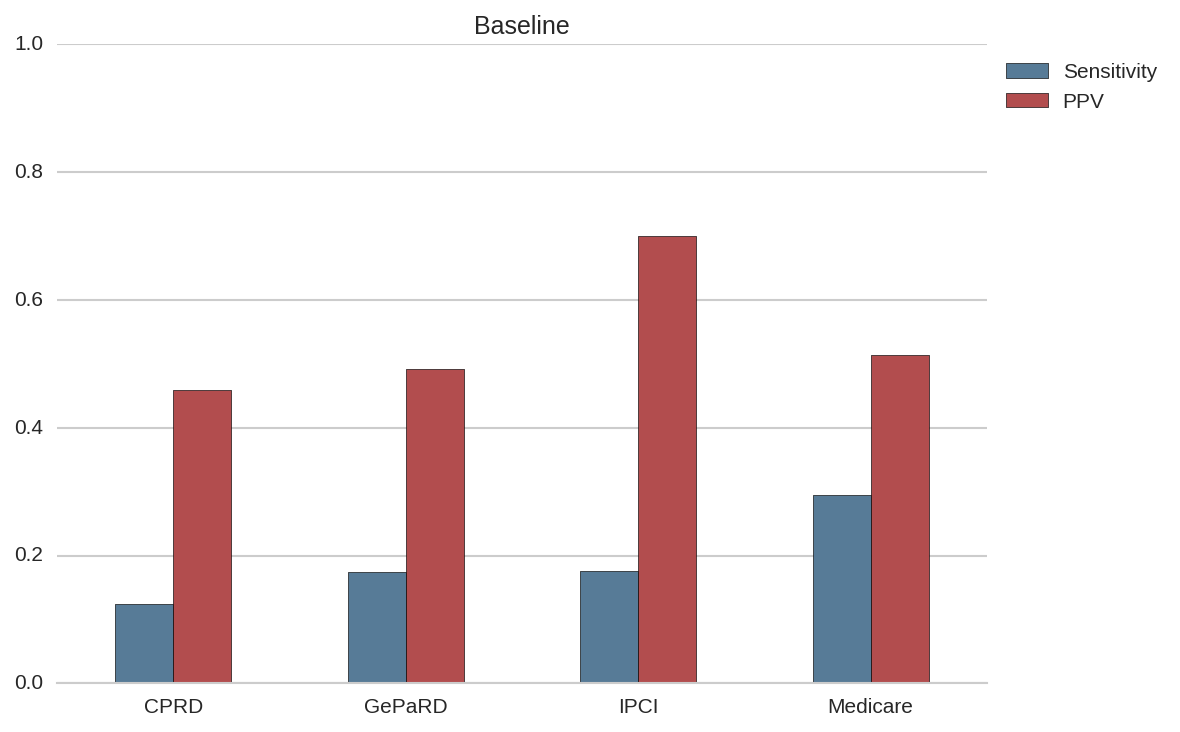

In [5]:
averages_compare = pd.DataFrame([
    ev[ev.variation == 'baseline'].groupby('database').recall.mean(),
    ev[ev.variation == 'baseline'].groupby('database').precision.mean(),
])
averages_compare.index = averages_compare.index.map(measure_label)
averages_compare.columns = averages_compare.columns.map(database_label)
with mystyle(measures_palette, savefig='baseline-performance-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title='Baseline')

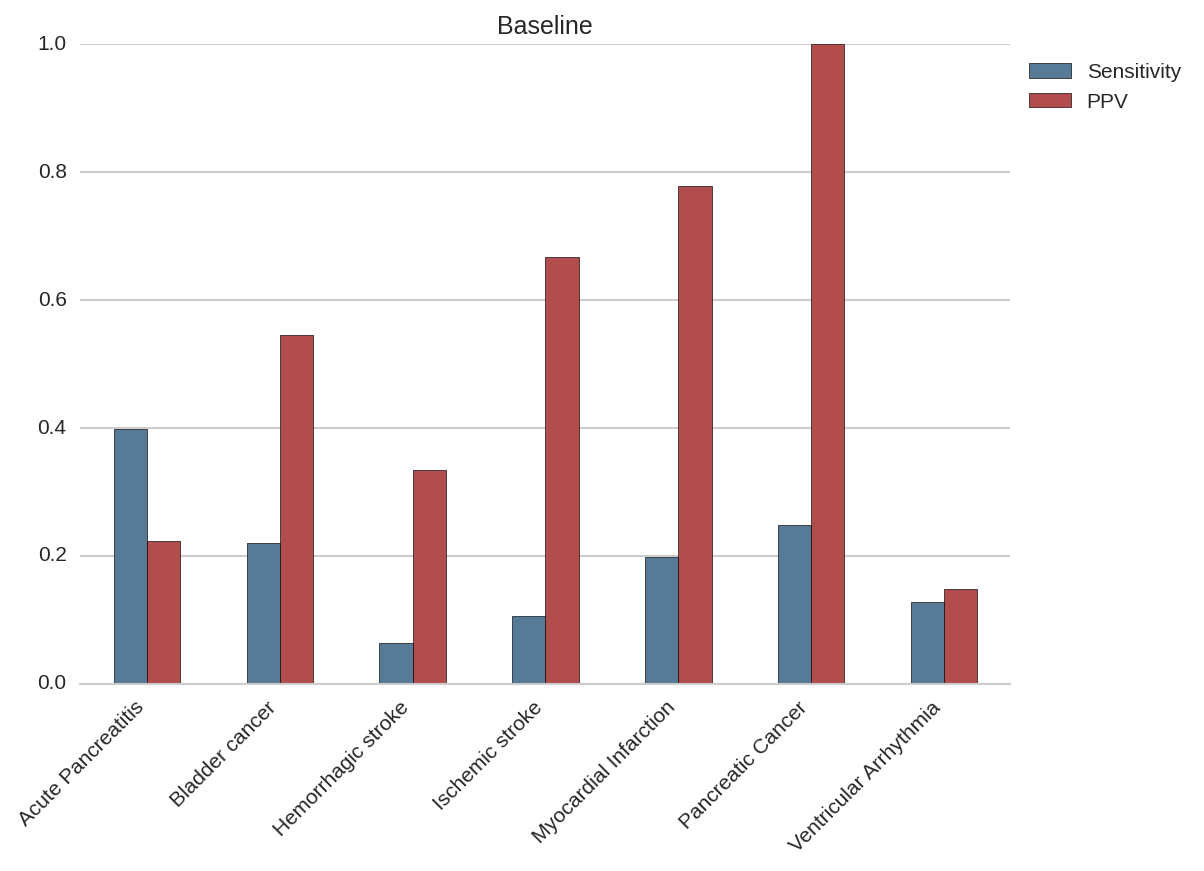

In [6]:
averages_compare = pd.DataFrame([
    ev[ev.variation == 'baseline'].groupby('event').recall.mean(),
    ev[ev.variation == 'baseline'].groupby('event').precision.mean(),
])
averages_compare.index = averages_compare.index.map(measure_label)
averages_compare.columns = averages_compare.columns.map(event_label)
with mystyle(measures_palette, xrot=45, ha='right', savefig='baseline-performance-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title='Baseline')

# Max-recall

,CPRD,GePaRD,IPCI,Medicare
Sensitivity,0.929871,0.938033,1,0.988095


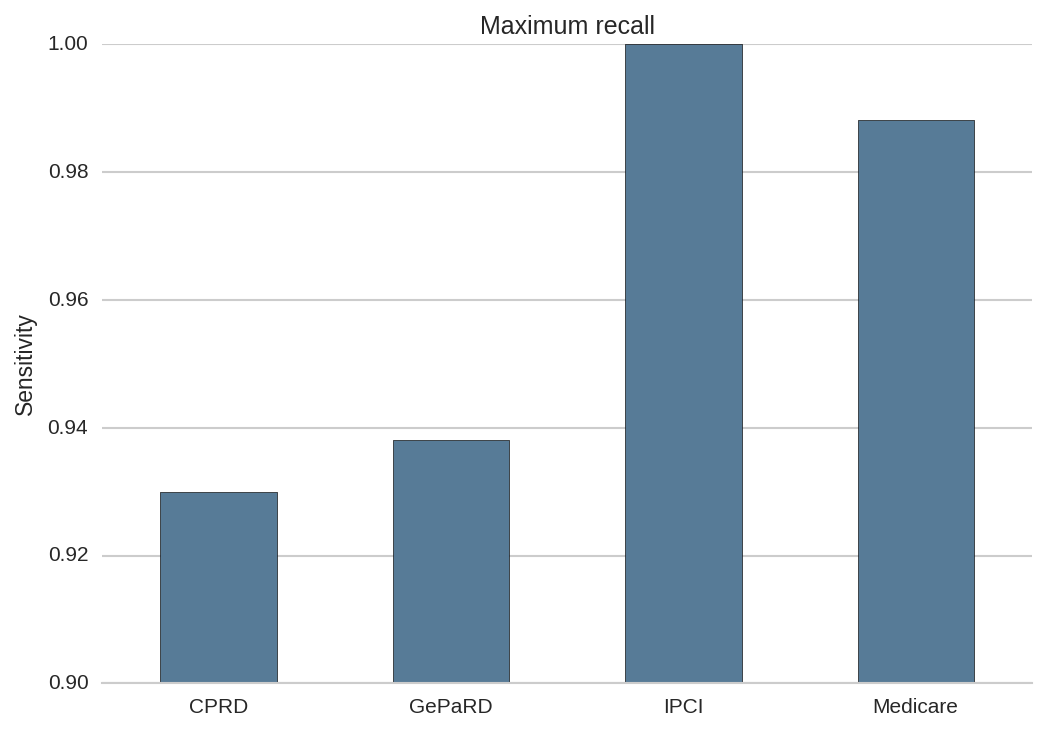

In [7]:
averages_compare = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('database').recall.mean(),
])
averages_compare.index = [measure_label('recall')]
averages_compare.columns = averages_compare.columns.map(database_label)
with mystyle(measures_palette, ylim=(.9,1), savefig='max-recall-by-db.pdf'):
    averages_compare.T.plot(kind='bar', legend=False, title='Maximum recall')
    plt.ylabel(measure_label('recall'))
averages_compare

## Reasons for imperfect sensitivity

In [8]:
stats = DataFrame()
stats['In mapping'] = code_stats[code_stats.InMapping]\
    .groupby('Database').Code.count()
stats['Not in maximum recall'] = code_stats[code_stats.InMapping & ~code_stats.InDnf]\
    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats['%'] = (stats['Not in maximum recall'] / stats['In mapping']).map("{:.2%}".format)
#stats['Not in maximum recall but in database'] = code_stats[code_stats.InMapping & code_stats.InDatabase & ~code_stats.InDnf]\
#    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats

,In mapping,Not in maximum recall,%
Database,,,
CPRD,229,14,6.11%
GePaRD,74,3,4.05%
IPCI,16,0,0.00%
Medicare,53,1,1.89%


In [9]:
max_recall_fn = ev[(ev.variation == 'max-recall') & (ev.recall < 1)][["database", "fn"]]
max_recall_fn.database = max_recall_fn.database.map(database_label)
max_recall_fn.fn = max_recall_fn.fn.fillna('[]').map(json.loads)
max_recall_fn = max_recall_fn.groupby('database').fn.sum().to_frame()
max_recall_fn.fn = max_recall_fn.fn.map(set).map(', '.join)
max_recall_fn.index.name = 'Database'
max_recall_fn.columns = ['False negatives of maximum recall']
max_recall_fn

,False negatives of maximum recall
Database,
CPRD,"7L1H6, BBd9., G61X., BA0z., G6W.., 7L1H7, BBaz., 1O0.., ByuE0, G64z4, BBa.., ByuE., G60X., G6X.."
GePaRD,"I21.9, I64, I46.0"
Medicare,410.X2


`CPRD`: READ2 codes from the reference are mapped to READ CTV3 codes that are not in UMLS, for example `7L1H6` (READ2) -> `XaM3E`, `XaPuP`, `7L1H6`, `7L1h6`.

`GePaRD`: Only 3 codes are missing, but those FN have large influence on sensitivity in mappings with few codes.

,Sensitivity
Acute Pancreatitis,1.000000
Bladder cancer,0.980769
Hemorrhagic stroke,0.986111
Ischemic stroke,0.939773
Myocardial Infarction,0.924603
Pancreatic Cancer,0.983945
Ventricular Arrhythmia,0.931481


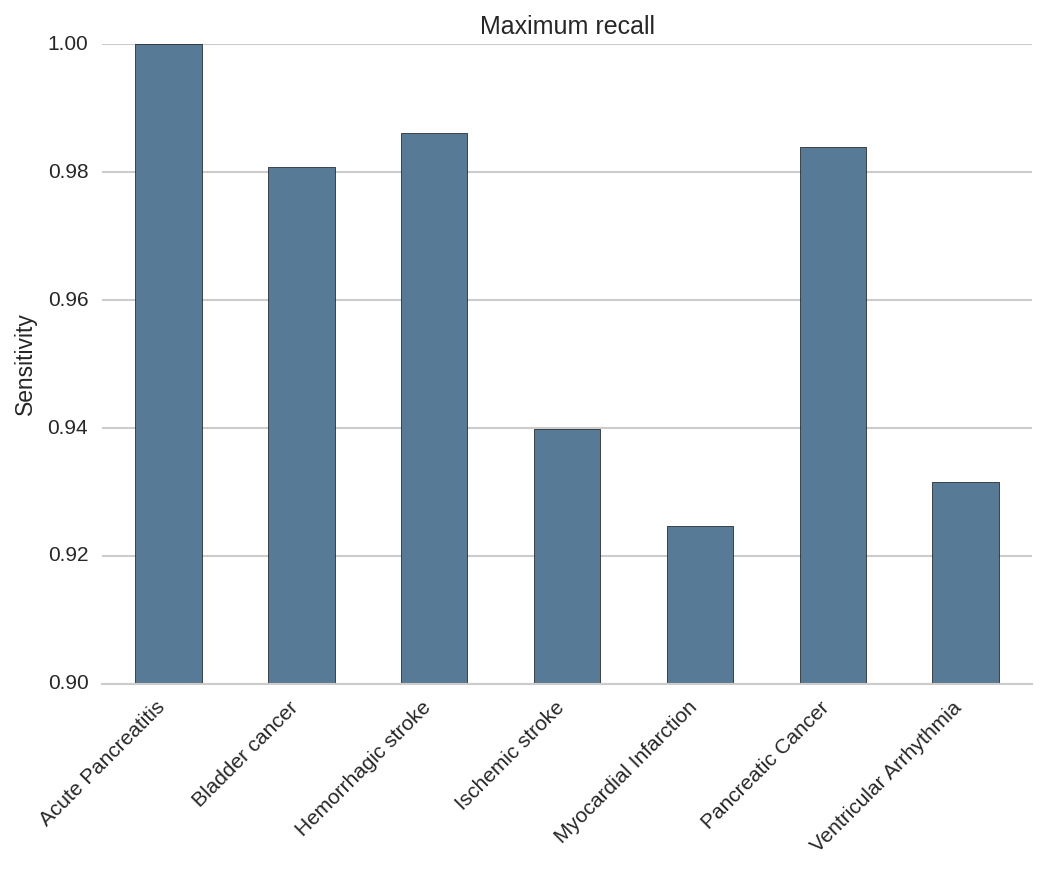

In [10]:
averages = ev[ev.variation == 'max-recall'].groupby('event').recall.mean()
averages.name = measure_label('recall')
averages.index = averages.index.map(event_names.get)
with mystyle(measures_palette, xrot=45, ha='right', ylim=(0.9,1), savefig='max-recall-by-event.pdf'):
    averages.plot(kind='bar', legend=False, title="Maximum recall")
    plt.ylabel(measure_label('recall'))
averages.to_frame()

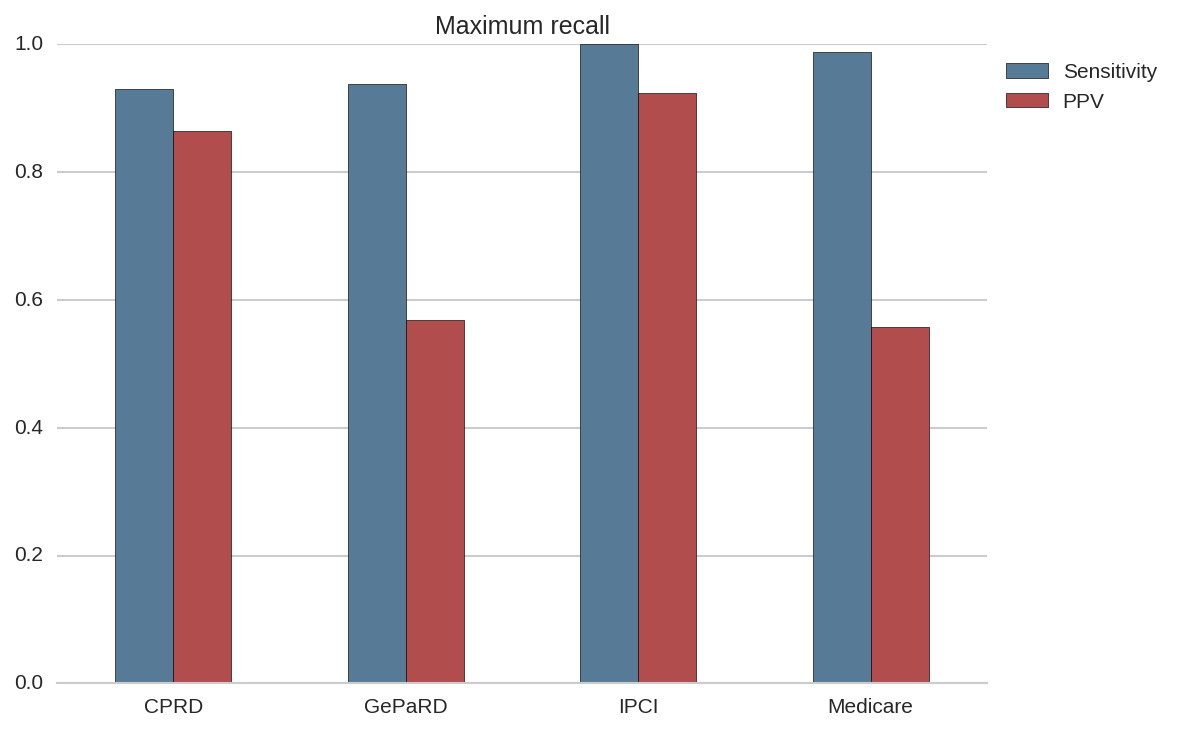

In [11]:
averages_compare = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('database').recall.mean(),
    ev[ev.variation == 'max-recall'].groupby('database').precision.mean(),
])
averages_compare.index = averages_compare.index.map(measure_label)
averages_compare.columns = averages_compare.columns.map(database_label)
with mystyle(measures_palette, savefig='max-recall-performance-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title='Maximum recall')

# Compare relations for expansion

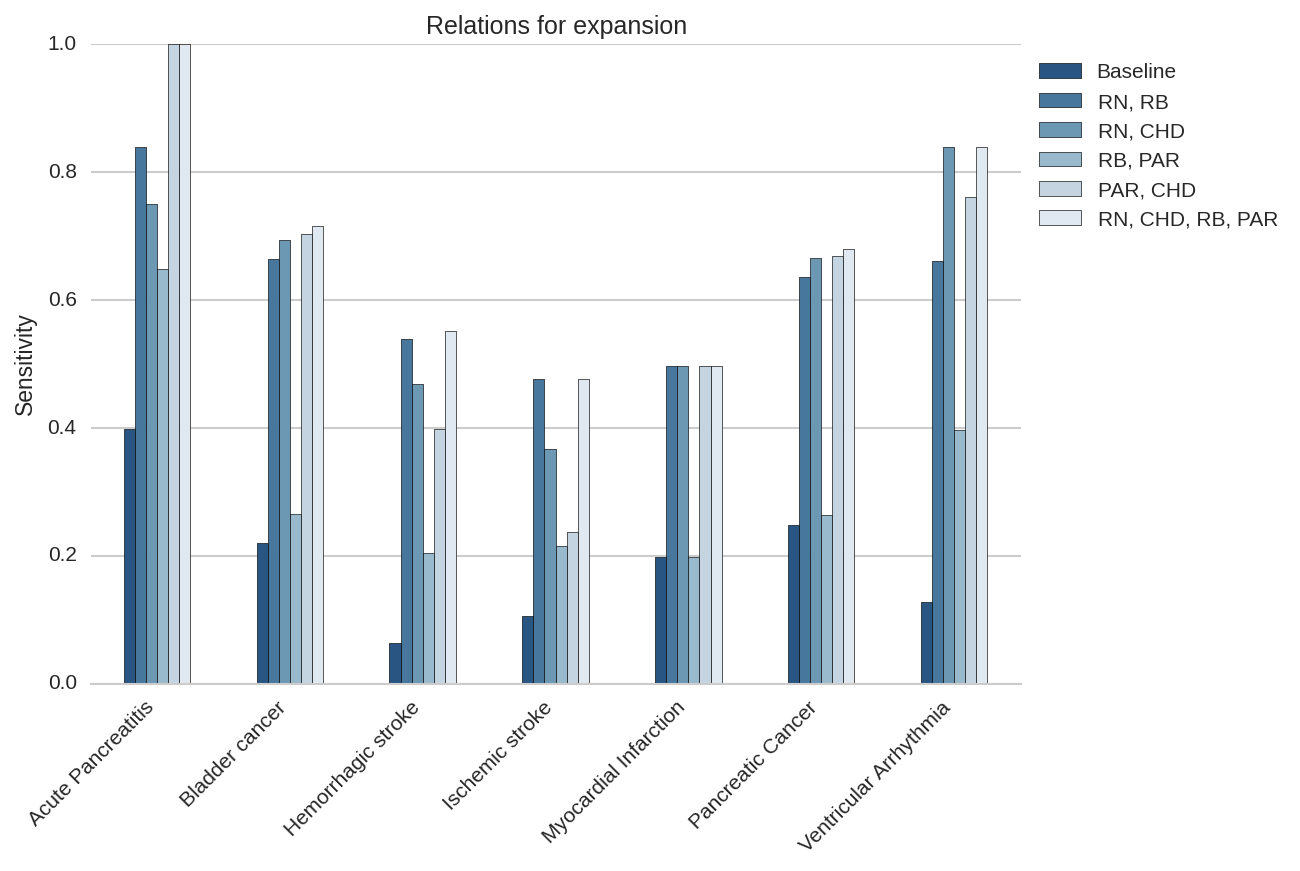

In [12]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()

with mystyle(graded_recall_palette(len(compare_variations)), xrot=45, ha='right', savefig='relations-recall-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Relations for expansion")
    plt.ylabel(measure_label('recall'))

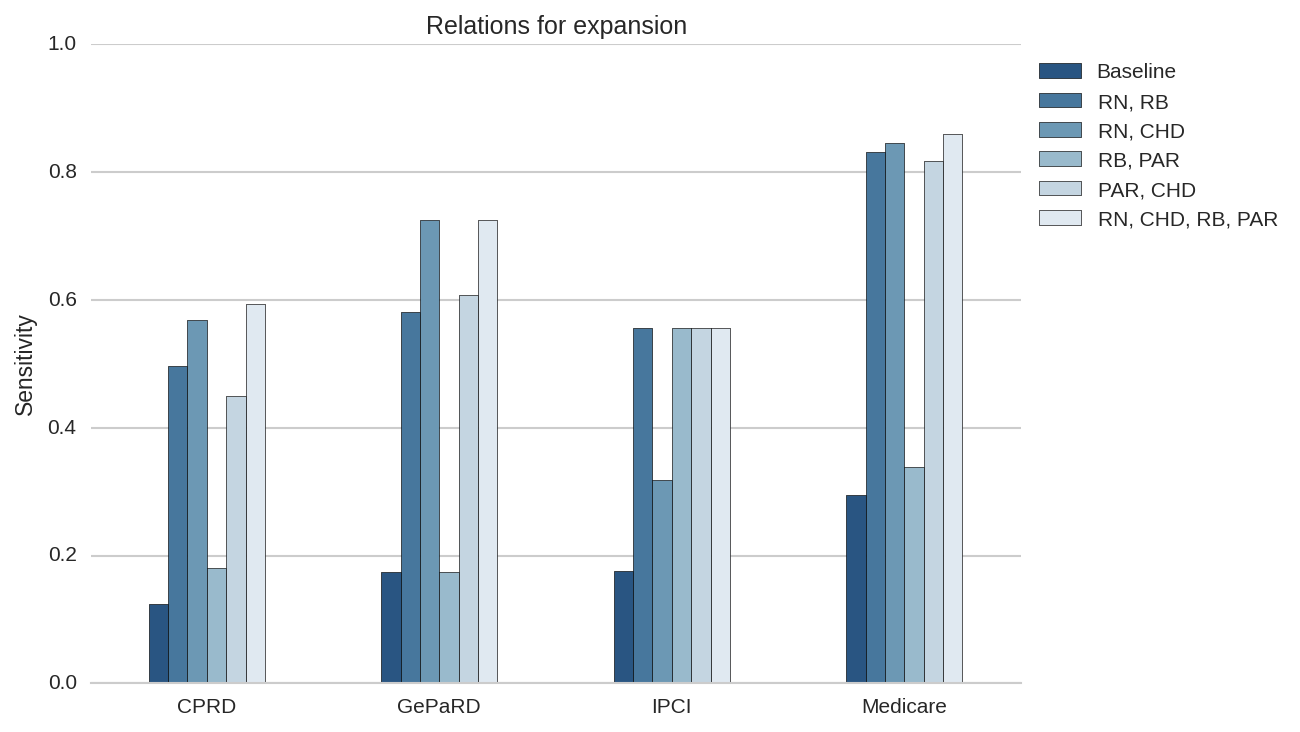

In [13]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
with mystyle(graded_recall_palette(len(compare_variations)), savefig='relations-recall-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Relations for expansion")
    plt.ylabel(measure_label('recall'))

# Increasing sensitivity with more expansion steps

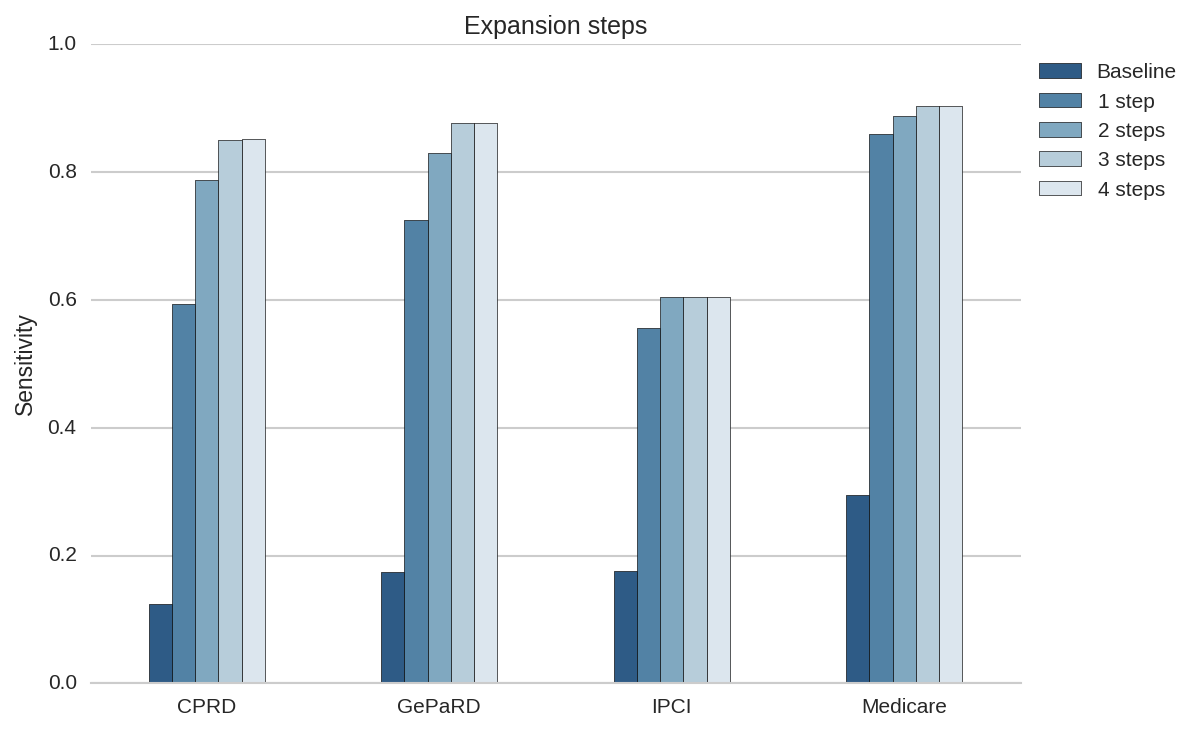

In [14]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()

with mystyle(graded_recall_palette(len(compare_variations)), savefig='steps-recall-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('recall'))

## Reasons for low performance in IPCI when including exclusion codes

*Exclusion codes are not in the evaluation any more. See note above.*

The IPCI mapping contains *very* broad codes that are refined with additional terms. For example

- `K24` (Fear of heart attack)
- `K90` (stroke)
- `K93` (Pulmonary embolism)
- `D70` (Dementia) OR "dementia" AND "infarct"
- `U14` (Kidney symptom/complaint ) OR "nier" AND "infarct"

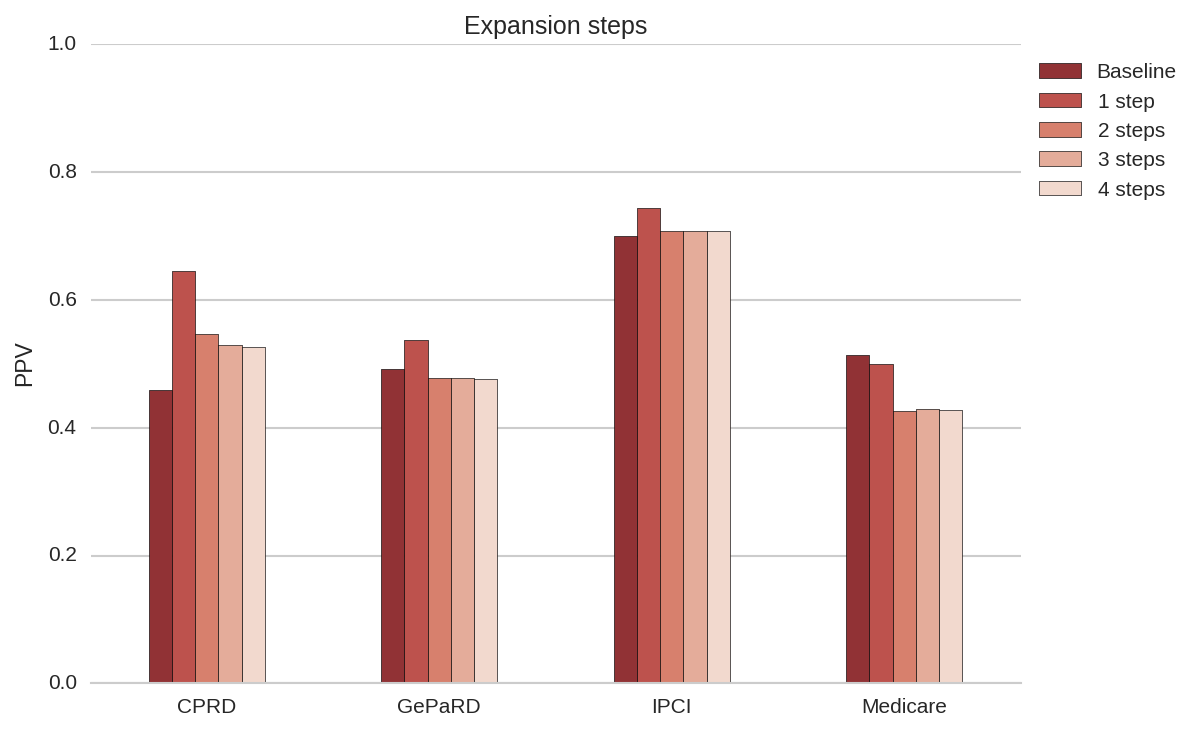

In [15]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()

with mystyle(graded_precision_palette(len(compare_variations)), savefig='steps-precision-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('precision'))

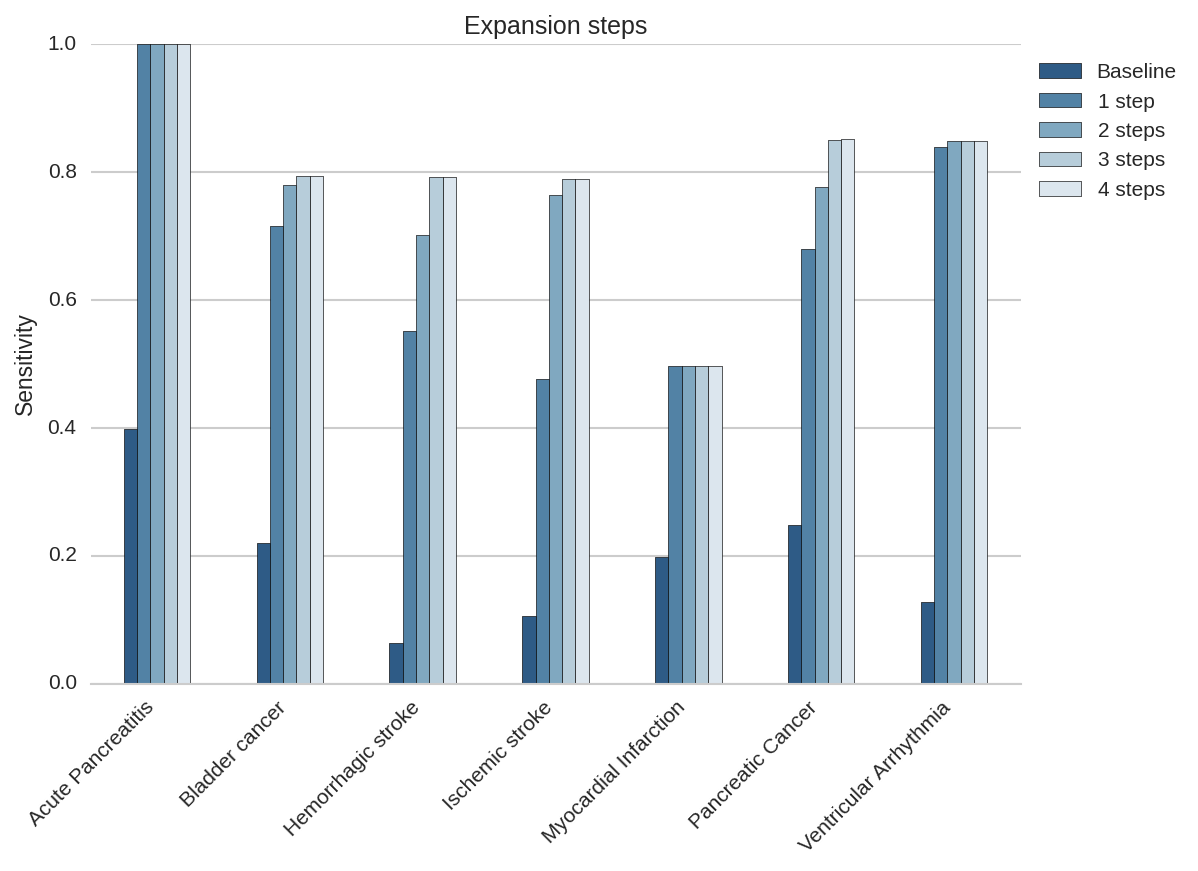

In [16]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()

with mystyle(graded_recall_palette(len(compare_variations)), xrot=45, ha='right', savefig='steps-recall-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('recall'))

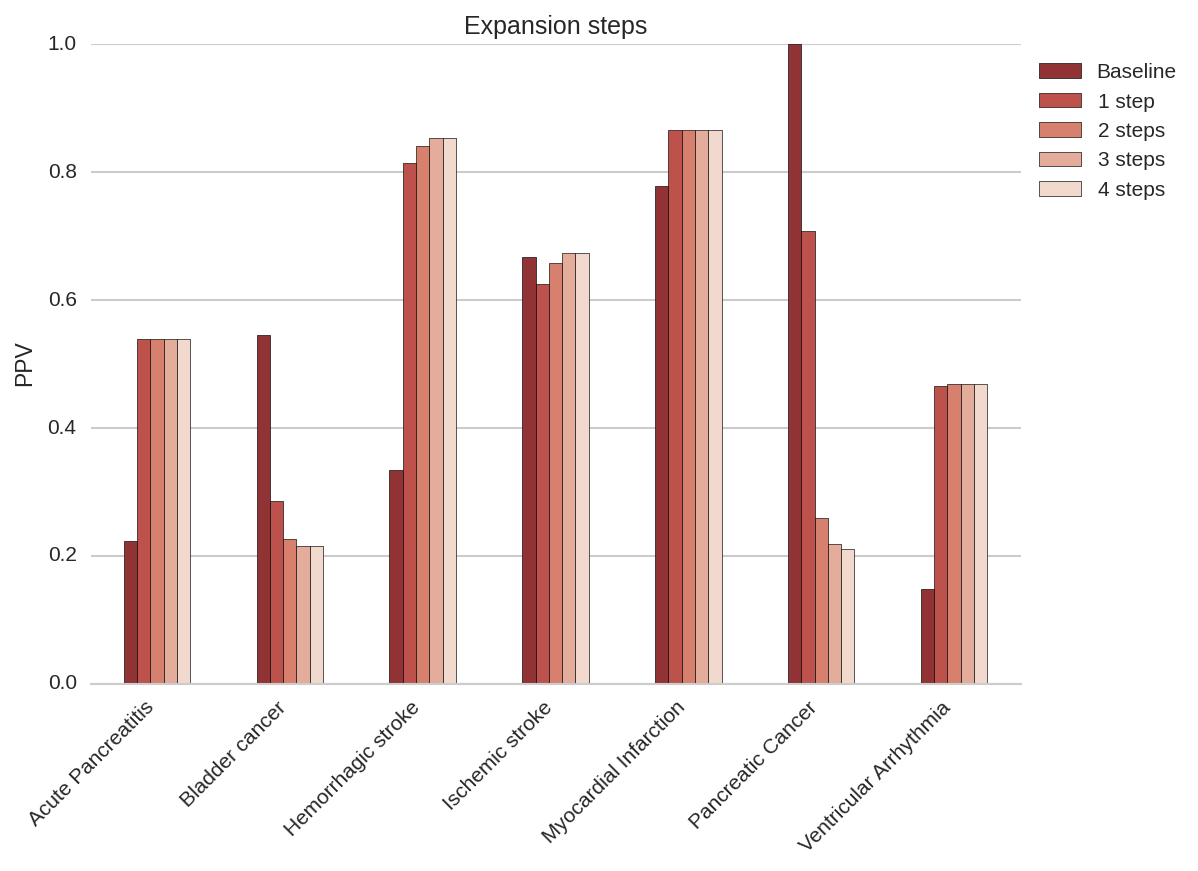

In [17]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right', savefig='steps-precision-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('precision'))

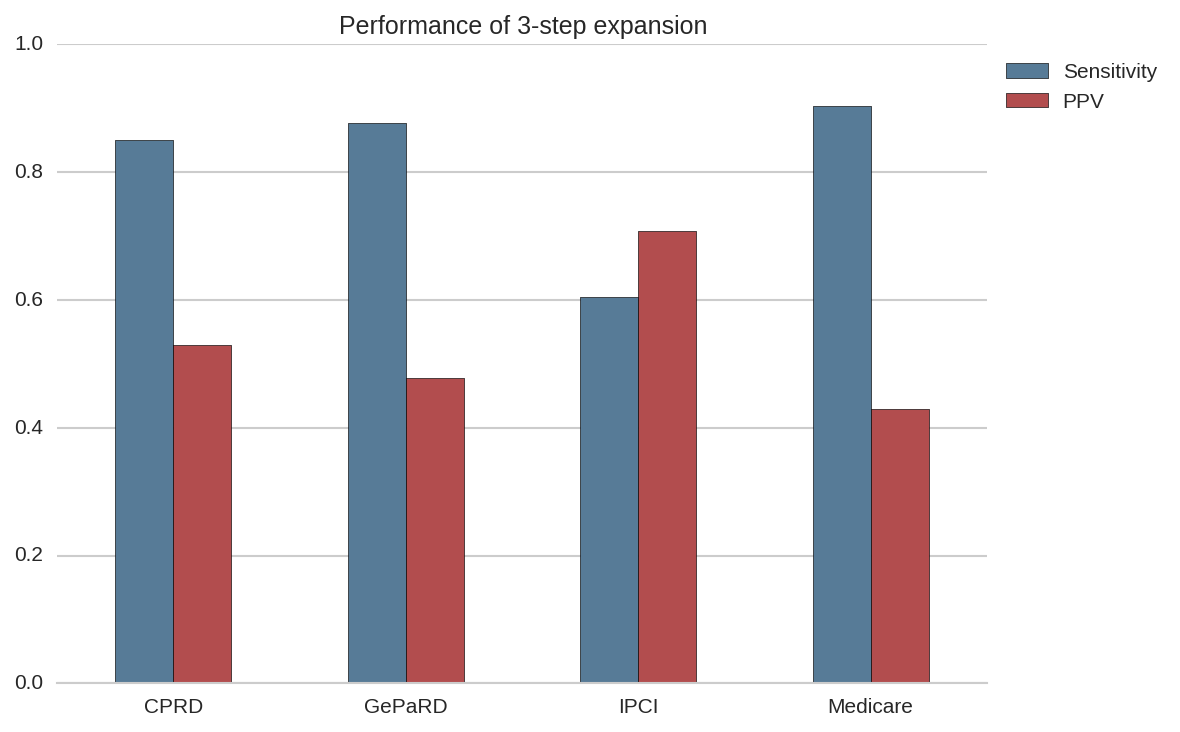

In [18]:
measures = ['recall', 'precision']
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('database')[measure].mean()
    for measure in measures
], index=map(measure_label, measures))
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(measures_palette, savefig='expansion3-performance-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Performance of 3-step expansion")

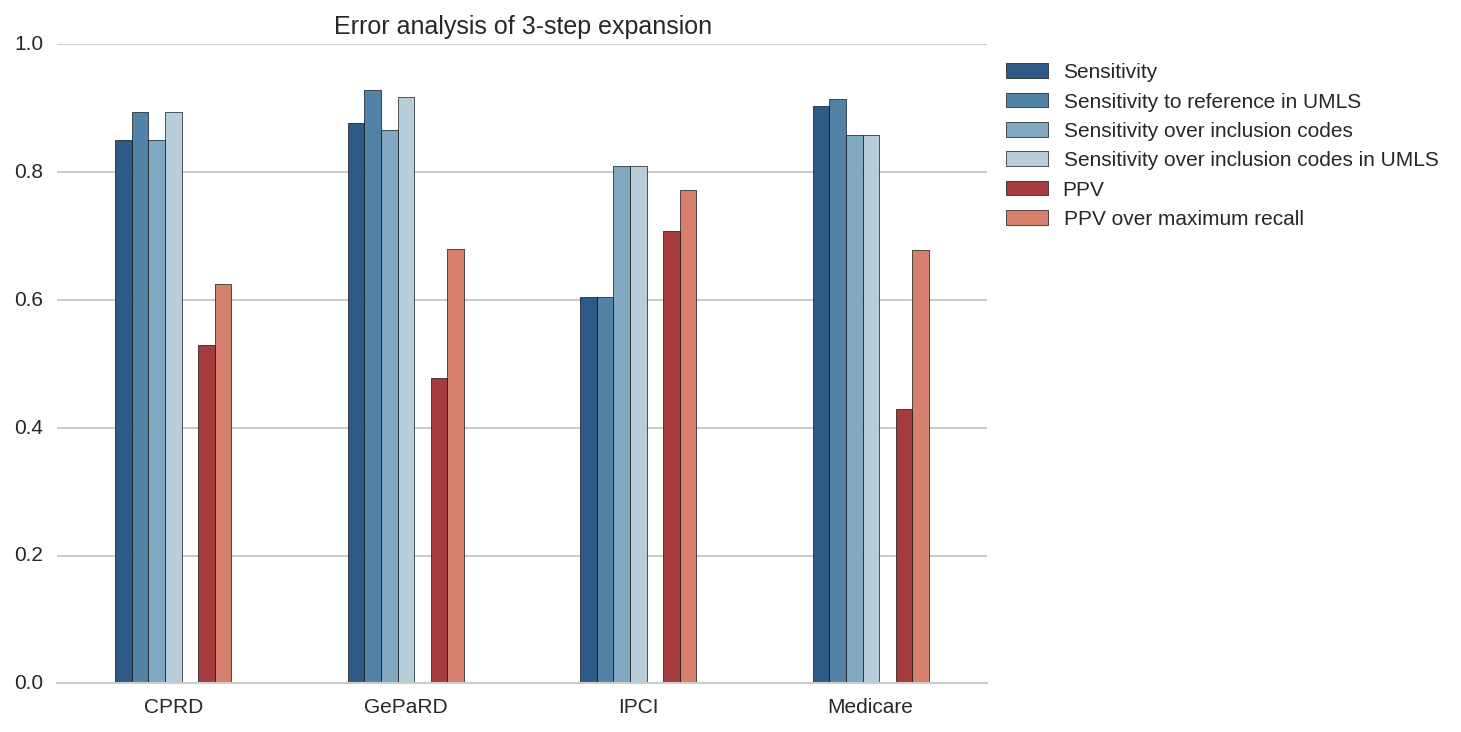

In [19]:
measures = OrderedDict([
    ('recall', measure_label('recall')),
    ('recall_in_umls', '{} to reference in UMLS'.format(measure_label('recall'))),
    ('recall_without_exclusions', '{} over inclusion codes'.format(measure_label('recall'))),
    ('recall_without_exclusions_in_umls', '{} over inclusion codes in UMLS'.format(measure_label('recall'))),
    ('', ''),
    ('precision', measure_label('precision')),
    ('precision_over_dnf', '{} over maximum recall'.format(measure_label('precision'))),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('database')[measure].mean()\
        if measure else\
        pd.Series([0] * len(ev.database.unique()), index=ev.database.unique())
    for measure in measures
], index=measures.values())
averages_compare.columns = averages_compare.columns.map(database_label)

p = sns.color_palette(graded_recall_palette(5)[:-1] + [(1,1,1)] + graded_precision_palette(3)[:-1])
with mystyle(p, savefig='expansion3-error-analysis-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Error analysis of 3-step expansion")

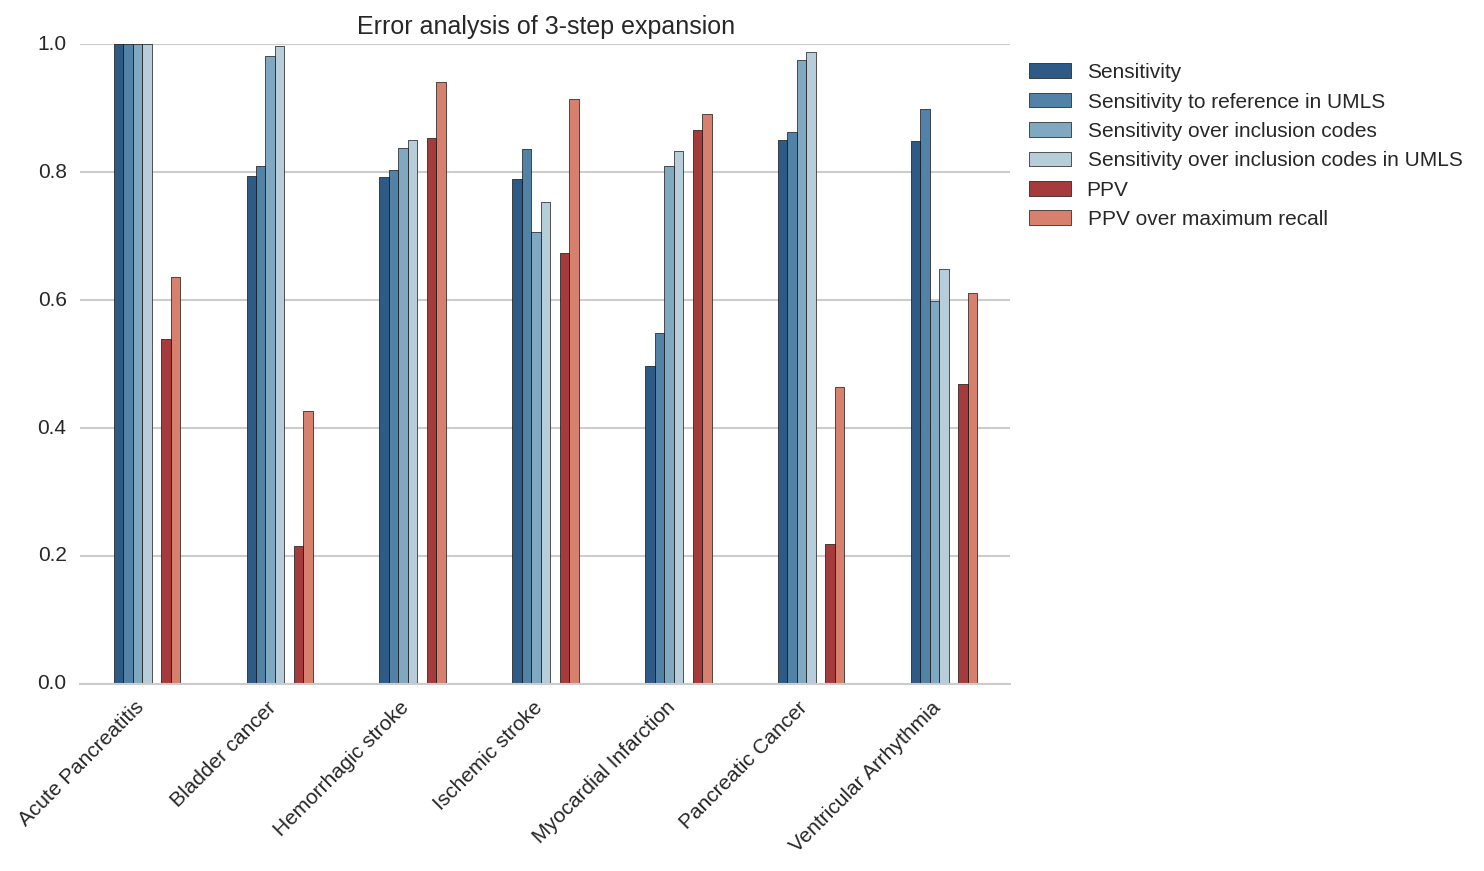

In [20]:
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('event')[measure].mean()\
        if measure else\
        pd.Series([0] * len(ev.event.unique()), index=ev.event.unique())
    for measure in measures
], index=measures.values())
averages_compare.columns = averages_compare.columns.map(event_label)

p = sns.color_palette(graded_recall_palette(5)[:-1] + [(1,1,1)] + graded_precision_palette(3)[:-1])
with mystyle(p, savefig='expansion3-error-analysis-by-db.pdf', xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Error analysis of 3-step expansion")

In [21]:
residuals = ev[ev.variation == '3-RN-CHD-RB-PAR.expand']\
    [['database', 'event', 'fn_inclusion_in_umls']]\
    .set_index(['event', 'database'])\
    .fn_inclusion_in_umls\
    .fillna('NaN').map(json.loads).map(lambda s: ', '.join(s) if type(s) == list else 'N/A')
residuals = residuals.unstack()
residuals.index = residuals.index.map(event_label)
residuals.columns = residuals.columns.map(database_label)
residuals

,CPRD,GePaRD,IPCI,Medicare
Acute Pancreatitis,,,,
Bladder cancer,1O0..,,,
Hemorrhagic stroke,"70041, 70042, 70043, 70082",,,
Ischemic stroke,G64z4,,,"433.01, 433.11, 433.21, 433.31, 433.81, 434.01"
Myocardial Infarction,N/A,"I21.0, I21.1, I21.2",,
Pancreatic Cancer,"1O0.., B8086, BB44., BB5C., BB5Cz",,,
Ventricular Arrhythmia,"3283., 7L1H., 7L1H4, 7L1H6, 7L1H7, 7L1Hy, 7L1Hz, 853.., 8531., 8532., 853Z.",,,


# Removing unused codes

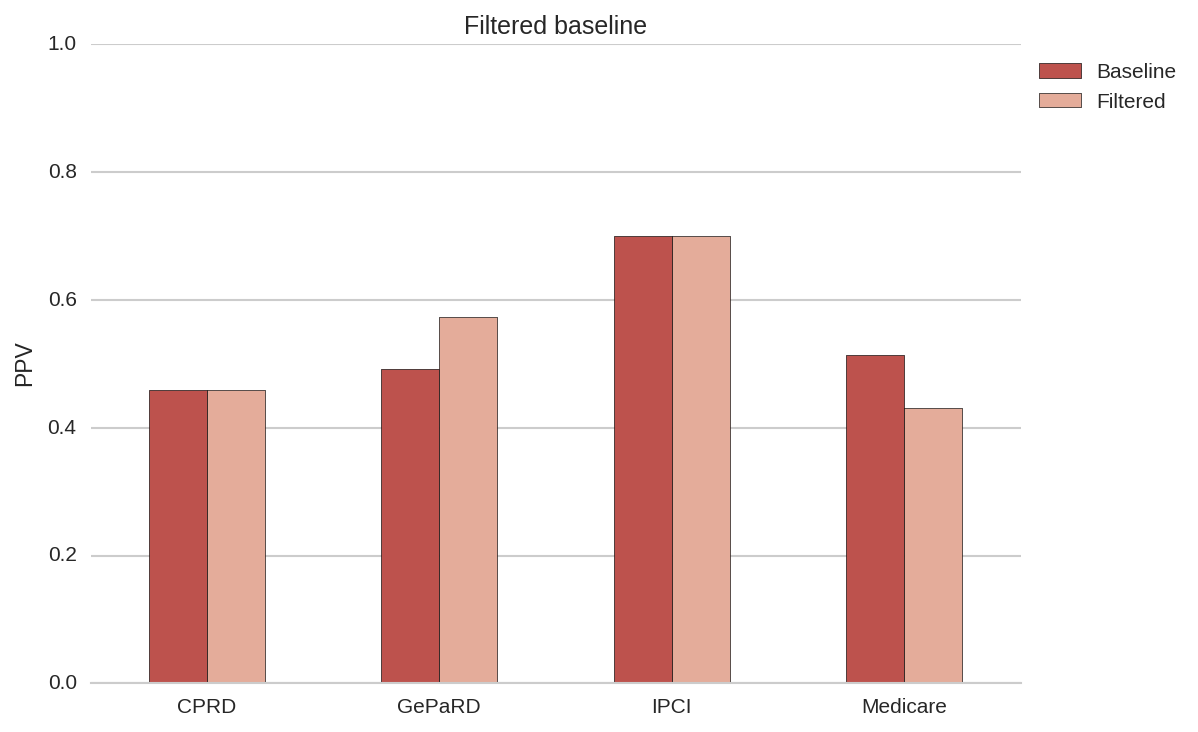

In [22]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations)), savefig='filtered-baseline-precision-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))

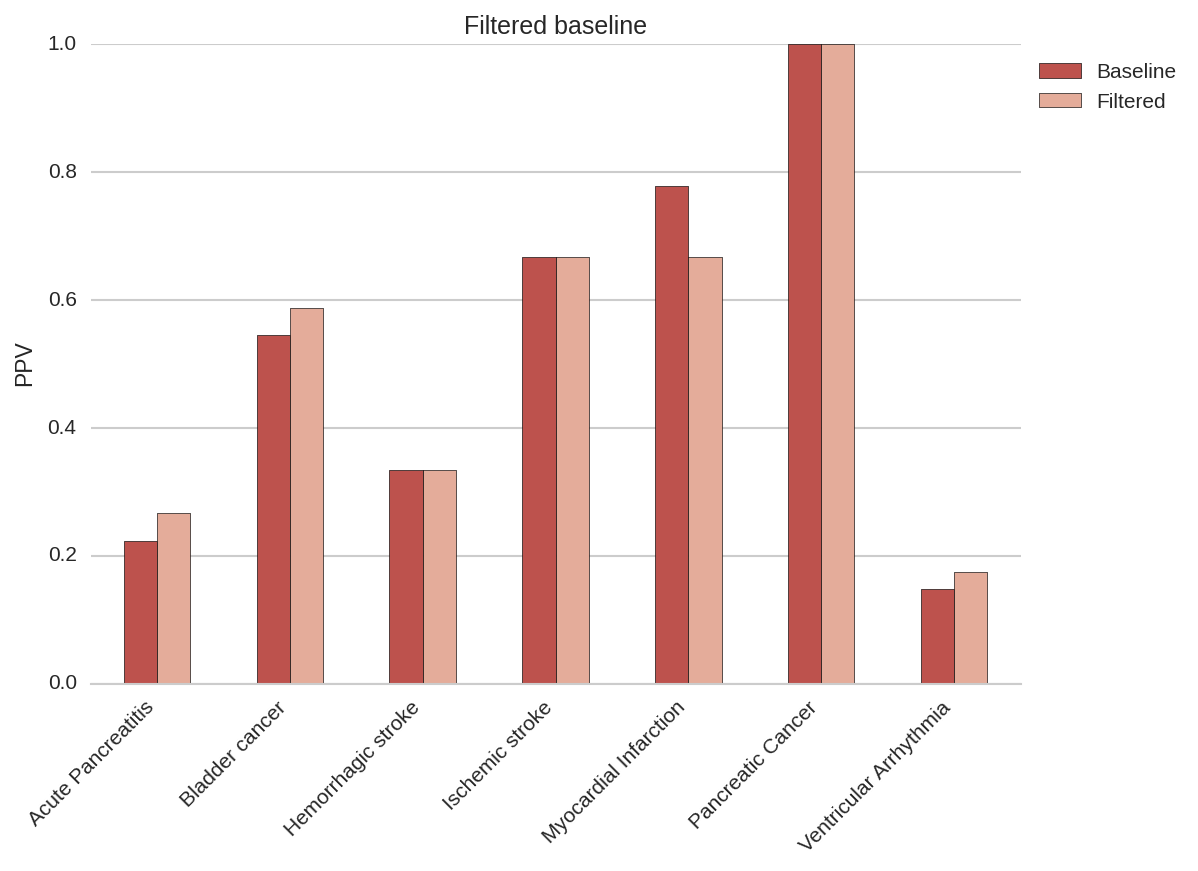

In [23]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_label)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-baseline-precision-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))

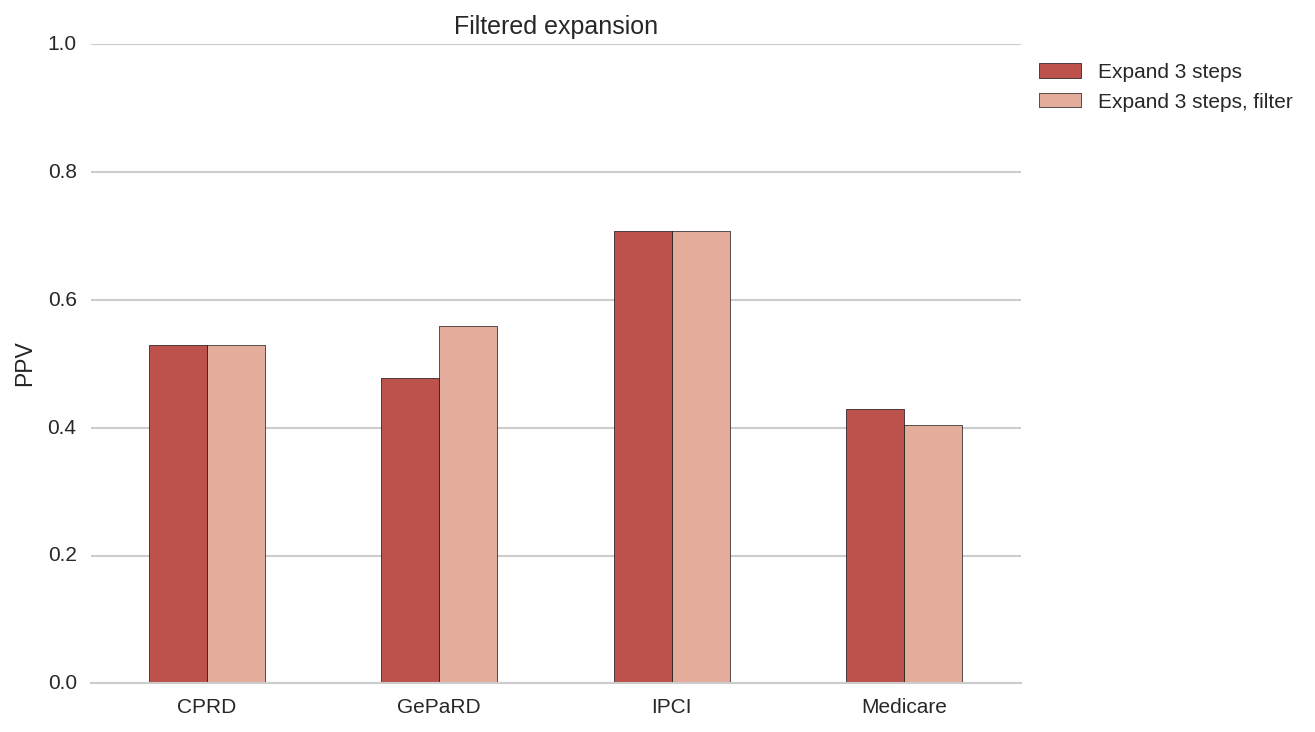

In [24]:
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations)), savefig='filtered-expansion3-precision-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered expansion")
    plt.ylabel(measure_label('precision'))

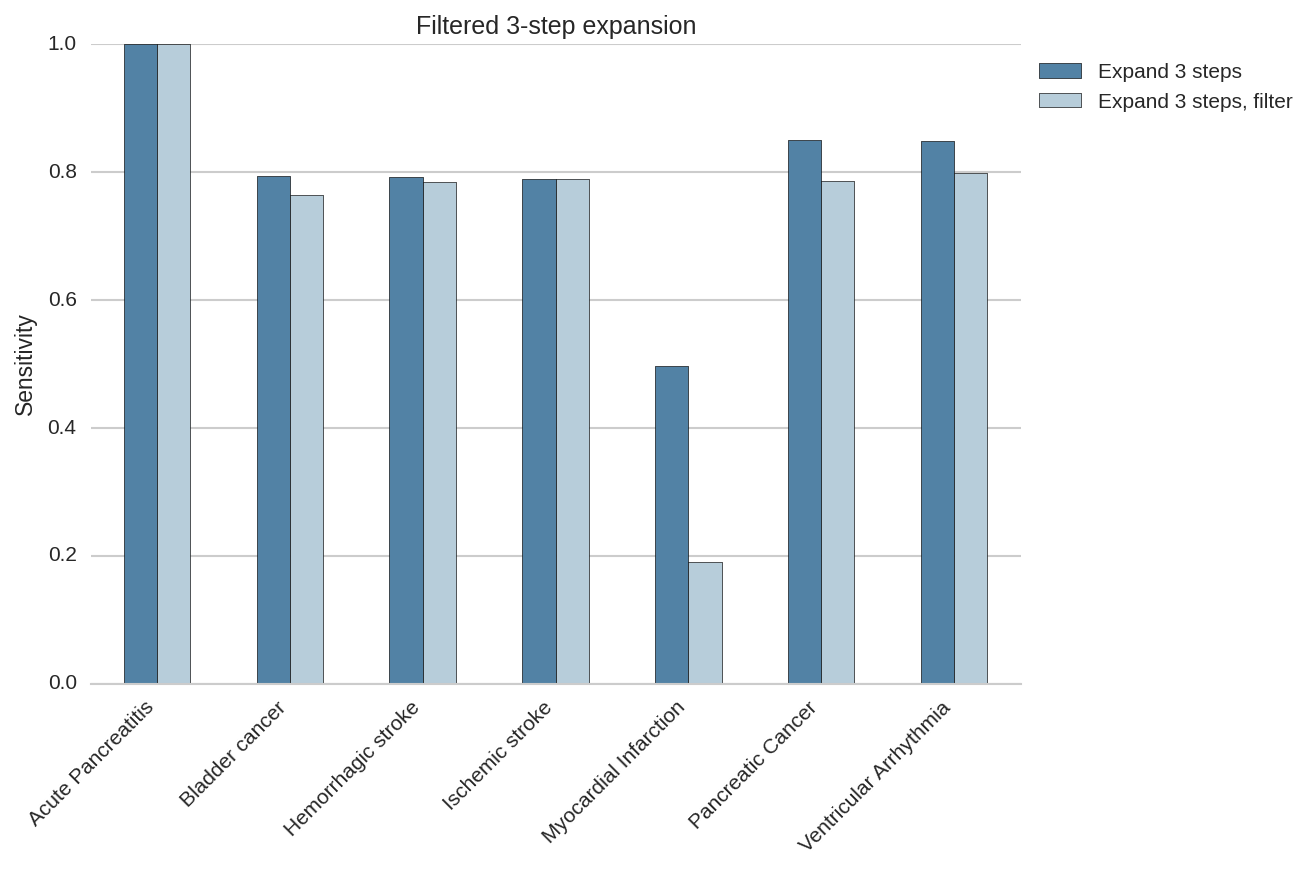

In [25]:
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_names.get)

with mystyle(graded_recall_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-expansion3-recall-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered 3-step expansion")
    plt.ylabel(measure_label('recall'))

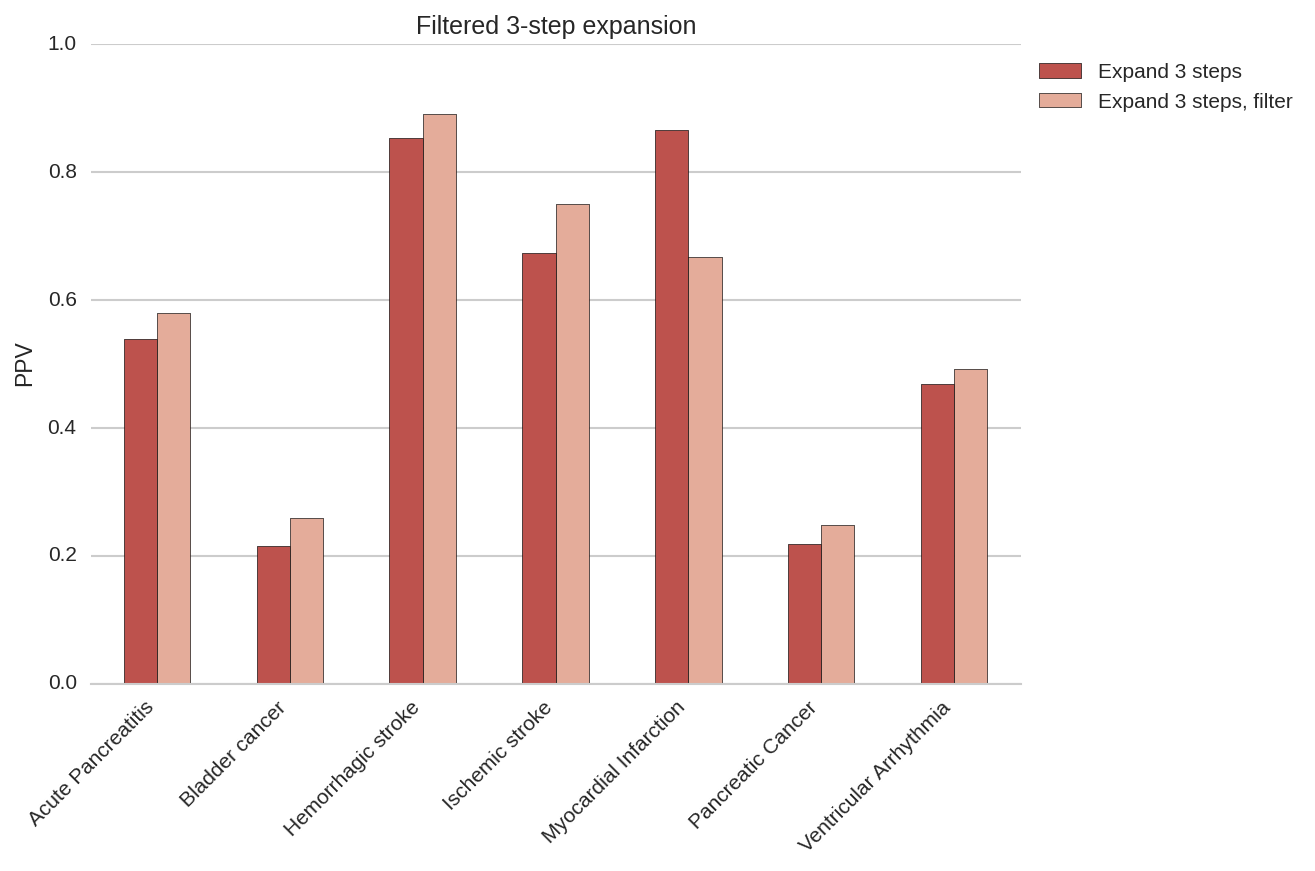

In [26]:
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_names.get)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-expansion3-precision-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered 3-step expansion")
    plt.ylabel(measure_label('precision'))

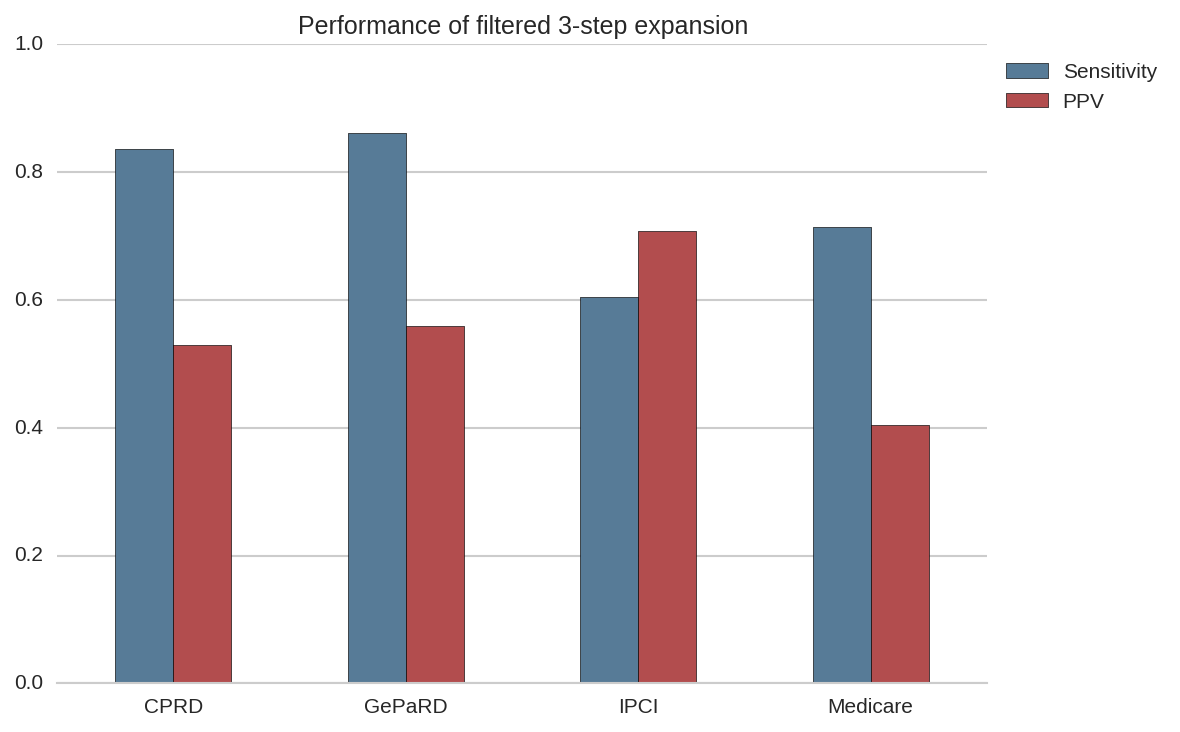

In [27]:
measures = ['recall', 'precision']
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand.filter-gen'].groupby('database')[measure].mean()
    for measure in measures
], index=map(measure_label, measures))
averages_compare.columns = averages_compare.columns.map(database_label)
#averages_compare.index = compare_variations.values()

with mystyle(measures_palette, savefig='filtered-expansion3-performance-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Performance of filtered 3-step expansion")

The drop in PPV for Myocardial infarction is caused by the mapping to codes `410.*` (Acute myocardial infarction) in Medicare which is *not* used in the ARS database.

# Codes in reference mappings, not in databases
Codes that might be removed from the TP when filtering.

In [28]:
stats = DataFrame()
stats['In ref'] = code_stats[code_stats.InMapping]\
    .groupby('Database').Code.count()
stats['Not in DB'] = code_stats[code_stats.InMapping & ~code_stats.InDatabase]\
    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats['%'] = (stats['Not in DB'] / stats['In ref']).map("{:.2%}".format)
stats['Codes'] = code_stats[code_stats.InMapping & ~code_stats.InDatabase]\
    .groupby('Database').Code.aggregate(lambda vs: ', '.join(set(vs)))
stats

,In ref,Not in DB,%,Codes
Database,,,,
CPRD,229,5,2.18%,"B91zz, Gyu60, ByuF., BB46., 8531."
GePaRD,74,1,1.35%,C25
IPCI,16,0,0.00%,NaN
Medicare,53,15,28.30%,"410, 410.7, 410.4, 410.1, 410.X2, 410.0, 427.4, 157, 188, 410.8, 410.6, 410.5, 410.2, 410.3, 410.9"
